In [ ]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.linear_model import LinearRegression

#change directory
os.chdir('/Users/jiwoonhwang/Desktop/MBTS/October 2022')

# path="/Users/jiwoonhwang/Desktop/MBTS/Final datasets/final_0m_dup_sqdg_zerofiltered_25percent.csv"
# relative_df=pd.read_csv(path, index_col=0, low_memory=False)

In [2]:
def pretty_C03_depth(template):
    for i in template.columns:
        i_split=i.split("_")
        if len(i_split[2])==2:
            i_new="_".join(i_split[0:2])+"_"+"00"+"_".join(i_split[2:4])
            template=template.rename(columns={i:i_new})
        if len(i_split[2])==3:
            i_new="_".join(i_split[0:2])+"_"+"0"+"_".join(i_split[2:4])
            template=template.rename(columns={i:i_new})
            
            
    for i in template.columns:
        i_split=i.split("_")
        if i_split[1]=="C3":
            i_new="MARS_C03_"+"_".join(i_split[2:4])
            template=template.rename(columns={i:i_new})
        
    return template

def combine_pos_neg(template1):
    for col in template1.columns:
        col_split=col.split("_")
        col_new="_".join(col_split[0:3])+"_"+col_split[3][-1]
        template1=template1.rename(columns={col:col_new})
    return template1
#template.columns.values

## Define normalization & quantification categories

<div class="alert alert-block alert-warning">
Need pigment standard curve before I can finish quantification (Sept 29 2022)
</div>

In [3]:
'''QUANTIFICATION'''

quant_species={}
samples=pd.read_csv("/Users/jiwoonhwang/Desktop/MBTS/July 2022/final_raw_with_info.csv", index_col=0, low_memory=False)

quant_species["DAG"]=['DAG', 'WaxEster', 'DG']
quant_species["MAG"]=['MAG', 'FFA']
quant_species["LPE"]=['LPG', 'LPA', 'LPE']
quant_species["LPC"]=['LPC','LDGCC','LDGDG','LDGTS_DGTA','LMGDG', 'LSQDG', 'unknown_MAG']
quant_species["PG"]=['PG','PC', 'PDPT', 'PE',                                                       ## Phospholipids
                   'CholesterolEsters', 'CoprostanolEsters', 'Cholesterol2H', 'CholesterolAcetate', ## Sterols
                   'SQDG', 'MGDG', 'DGDG', 'DGGA',                                                  ## Glycolipids
                   'BLL', 'DGTS_DGTA', 'DGCC', 'S_DGCC',                                            ## Betaine lipids
                   'PQ9OH',  'PQ9OH2',                                                              ## Plastiquinone
                   'UQ2:2',  'UQ4:4', 'UQ7:7',  'UQ8:8',  'UQ9:9',                                  ## Ubiquinone
                   'unknown_DAG', 'unknown']
quant_species["TAG"]=["TAG"]
quant_species["pigments"]=[]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiwoonhwang/Desktop/MBTS/July 2022/final_raw_with_info.csv'

### get std for normalization

In [4]:
#path ="/Users/jiwoonhwang/Desktop/MBTS/20min_method/Positive/standard_corrected_prettynames.csv"
path ="/Users/jiwoonhwang/Desktop/MBTS/October 2022/standard_corrected_PC_prettynames.csv"
standard_20min =pd.read_csv(path, index_col=0)
path ="/Users/jiwoonhwang/Desktop/MBTS/48min_method/standard_corrected.csv"
standard_48min =pd.read_csv(path, index_col=0)
path="/Users/jiwoonhwang/Desktop/MBTS/20min_method/Negative/standard_corrected.csv"
standard_neg=pd.read_csv(path, index_col=1)
standard_neg=standard_neg.rename(columns={'MARS_C3_150_neg1':'MARS_C3_150m_neg1','MARS_C3_150_neg3':'MARS_C3_150m_neg3'})


standard_20min=combine_pos_neg(pretty_C03_depth(standard_20min.loc[:,"MARS_C25_0m_pos1":"MARS_C38_75m_pos3"]))
standard_48min=combine_pos_neg(pretty_C03_depth(standard_48min.loc[:,'M1_C2_10m_pos1':"MARS_C38_75m_pos3"]))
standard_neg=combine_pos_neg(pretty_C03_depth(standard_neg.loc[:,"MARS_C25_0m_neg1":"MARS_C38_75m_neg3"]))

In [5]:
standard_20min=standard_20min.rename(index={"LYSO PC (18:1 D7)":"LPC", "Lyso PE (15:0-18:1(d7))":"LPE"})
standard_48min=standard_48min.rename(index={"TAG (M+NH4)":"TAG"})

std_pos=standard_20min.copy()
std_pos.loc["TAG"]=standard_48min.loc["TAG"]

#std_pos

## Normalize raw

##### Positive 20min that have been manually verified, no TAGs

In [6]:
path="/Users/jiwoonhwang/Desktop/MBTS/July-August 2022/Pos_20min_annotated_noTAG_prettynames.csv"
temp1=pd.read_csv(path, low_memory=False, index_col="compounds")
temp1=temp1[temp1.index!="LMGDG 16:3 +4O"]

#------ Replace unknown with unknown_MAG, unknown_DAG, unknown
temp1.loc[(temp1['lipid_class']=='IP_MAG')&(temp1['species']=='unknown'), "species"]="unknown_MAG"
temp1.loc[(temp1['lipid_class']=='IP_DAG')&(temp1['species']=='unknown'), "species"]="unknown_DAG"

template1=pretty_C03_depth(temp1.loc[:,"MARS_C25_0m_pos1":"MARS_C38_75m_pos3"])

for col in template1.columns:
    col_split=col.split("_")
    col_new="_".join(col_split[0:3])+"_"+col_split[3][-1]
    template1=template1.rename(columns={col:col_new})

#-------- Add info ------
lst=temp1.loc[:,"elem_formula":"mzXML_pos"].columns.tolist()+temp1.loc[:,"xcms_peakgroup":].columns.tolist()
template1_info=pd.concat([template1,temp1.loc[:,lst]], axis=1)


In [7]:
template1_info["species"].unique()

array(['Pheophytin_a', 'PE', 'unknown_DAG', 'PC', 'DAG', 'unknown', 'PG',
       'SQDG', 'unknown_MAG', 'DGCC', 'MGDG', 'DGTS_DGTA', 'LPC', 'LDGCC',
       'LMGDG', 'UQ7:7', 'LPE', 'LDGTS_DGTA', 'Lut,Zeax', 'DGGA',
       'Neox_Nos,Pras,Viol'], dtype=object)

##### Positive 20min c1, no TAGs

In [8]:
path="/Users/jiwoonhwang/Desktop/MBTS/July-August 2022/LOB_nonorm_con_nodups_prettyname.csv"
temp2=pd.read_csv(path, low_memory=False, index_col="compound_name")

### remove TAGs, SQDG from C1 LOBSTAHS annotations 
temp2=temp2.loc[~temp2.index.str.startswith("TAG")]
temp2=temp2.loc[temp2["species"]!="SQDG"]

template2=pretty_C03_depth(temp2.loc[:,"MARS_C25_0m_pos1":"MARS_C38_75m_pos3"])

for col in template2.columns:
    col_split=col.split("_")
    col_new="_".join(col_split[0:3])+"_"+col_split[3][-1]
    template2=template2.rename(columns={col:col_new})
    
### Add info 
lst=temp2.loc[:,"elem_formula":"mzXML_pos"].columns.tolist()+temp2.loc[:,"xcms_peakgroup":].columns.tolist()
template2_info=pd.concat([template2,temp2.loc[:,lst]], axis=1)

#print(len(template2_info)-len(temp2))
# template2.columns.values

##### Negative 20min (SQDG, FFA)

In [9]:
path="/Users/jiwoonhwang/Desktop/MBTS/20min_method/Negative/LOB_Peaklist_neg.csv"
temp4_raw=pd.read_csv(path, low_memory=False)
temp4_raw=temp4_raw.loc[(~temp4_raw["compound_name"].isna())&(temp4_raw['C3f']==0)&(temp4_raw['C3c']==0)] ###remove NA and C3f, C3c unconfidence

dups=temp4_raw[temp4_raw["compound_name"].duplicated(keep=False)]
dups["compound_name"]=dups["compound_name"]+"_RT:"+dups["peakgroup_rt"].round(3).astype("str")
temp4_raw=temp4_raw.drop_duplicates('compound_name', keep=False)
temp4_raw=temp4_raw.append(dups)

# temp4_raw['compound_name'].loc[temp4_raw['C3f'] == 1] = temp4_raw['compound_name'].astype(str)+"_c3f"
# temp4_raw['compound_name'].loc[temp4_raw['C3c'] == 1] = temp4_raw['compound_name'].astype(str)+"_c3c"

temp4_raw=temp4_raw.set_index("compound_name")

temp4_raw=temp4_raw.loc[temp4_raw.index.str.startswith(tuple(["FFA", "SQDG"])),:]  ### Use only FFA and SQDG

##rename different columns 
temp4_raw=temp4_raw.rename(columns={'MARS_C3_150_neg1':'MARS_C3_150m_neg1','MARS_C3_150_neg3':'MARS_C3_150m_neg3'})

template4=pretty_C03_depth(temp4_raw.loc[:,"MARS_C25_0m_neg1":"MARS_C38_75m_neg3"])   

### Rename columns pos123 neg123 -> 123
for col in template4.columns:
    col_split=col.split("_")
    col_new="_".join(col_split[0:3])+"_"+col_split[3][-1]
    template4=template4.rename(columns={col:col_new})

    
### Add info 
lst=temp4_raw.loc[:,"elem_formula":"mzXML_neg"].columns.tolist()+temp4_raw.loc[:,"xcms_peakgroup":].columns.tolist()
template4_info=pd.concat([template4,temp4_raw.loc[:,lst]], axis=1)

/var/folders/ym/lsk3txk57xb_wzgsxbrb83tw0000gn/T/ipykernel_10856/3085861532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups["compound_name"]=dups["compound_name"]+"_RT:"+dups["peakgroup_rt"].round(3).astype("str")
/var/folders/ym/lsk3txk57xb_wzgsxbrb83tw0000gn/T/ipykernel_10856/3085861532.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp4_raw=temp4_raw.append(dups)


##### Positive 48min that have been verified (TAGs)

In [10]:
path="/Users/jiwoonhwang/Desktop/MBTS/48min_method/TAG_con_surface_raw_with_info_BLANK.csv"
temp5=pd.read_csv(path, low_memory=False, index_col=0)

# template5=template5.loc[:, :"MARS_C38_000m_pos3"]
template5=pretty_C03_depth(temp5.loc[:,:"MARS_C15_BLANK_pos3"])

for col in template5.columns:
    col_split=col.split("_")
    col_new="_".join(col_split[0:3])+"_"+col_split[3][-1]
    template5=template5.rename(columns={col:col_new})


### Add info 
lst=temp5.loc[:,"elem_formula":"mzXML_pos"].columns.tolist()+temp5.loc[:,"xcms_peakgroup":].columns.tolist()
template5_info=pd.concat([template5,temp5.loc[:,lst]], axis=1)

#### Combine templates

In [11]:
combined=pd.concat([template1, template2, template4, template5]) 
combined=combined.reindex(sorted(combined.columns), axis=1)
print (len(combined))
print (combined.index[combined.index.duplicated(keep="first")])
combined=combined[~combined.index.duplicated(keep="first")]
print (len(combined))

1119
Index([], dtype='object')
1119


In [12]:
combined_info=pd.concat([template1_info, template2_info, template4_info, template5_info]) 
combined_info=combined_info.reindex(sorted(combined_info.columns), axis=1)
print (len(combined_info))
print (combined_info.index[combined_info.index.duplicated(keep="first")])
combined_info=combined_info[~combined_info.index.duplicated(keep="first")]
print (len(combined_info))

1119
Index([], dtype='object')
1119


In [163]:
combined.sort_index().sort_index(axis=1).to_csv("final_raw.csv")

In [164]:
combined_info.sort_index().sort_index(axis=1).to_csv("final_raw_with_info.csv")

### Normalize to PE

In [13]:
template1_norm_PE=pd.DataFrame(columns=template1.columns)
to_norm=template1
#print (i, to_norm.index)

##find highest value
value=standard_20min.loc[["PE"]].max(axis=1)
#print "This is the highest value: " +str(value)

##calculate normalizing factor
std= standard_20min.loc[["PE"]].apply(lambda row: row/float(value), axis=1)
factor= std.iloc[0,:]

##apply factor to peaklist
temp=to_norm.apply(lambda row: row/factor, axis=1)
template1_norm_PE=pd.concat([template1_norm_PE, temp])

In [14]:
template2_norm_PE=pd.DataFrame(columns=template2.columns)
to_norm=template2
#print (i, to_norm.index)

##find highest value
value=standard_20min.loc[["PE"]].max(axis=1)
#print "This is the highest value: " +str(value)

##calculate normalizing factor
std= standard_20min.loc[["PE"]].apply(lambda row: row/float(value), axis=1)
factor= std.iloc[0,:]

##apply factor to peaklist
temp=to_norm.apply(lambda row: row/factor, axis=1)
template2_norm_PE=pd.concat([template2_norm_PE, temp])

In [15]:
template4_norm_PE=pd.DataFrame(columns=template4.columns)
to_norm=template4
#print (i, to_norm.index)

##find highest value
value=standard_neg.loc[["PE"]].max(axis=1)
#print "This is the highest value: " +str(value)

##calculate normalizing factor
std= standard_neg.loc[["PE"]].apply(lambda row: row/float(value), axis=1)
factor= std.iloc[0,:]

##apply factor to peaklist
temp=to_norm.apply(lambda row: row/factor, axis=1)
template4_norm_PE=pd.concat([template4_norm_PE, temp])

In [16]:
#------- Normalize to PE ------
template5_norm_PE=pd.DataFrame(columns=template5.columns)
to_norm=template5
#print (i, to_norm.index)

##find highest value
value=standard_48min.loc[["PE (M+Na)"]].max(axis=1)
#print "This is the highest value: " +str(value)

##calculate normalizing factor
std= standard_48min.loc[["PE (M+Na)"]].apply(lambda row: row/float(value), axis=1)
factor= std.iloc[0,:]

##apply factor to peaklist
temp=to_norm.apply(lambda row: row/factor, axis=1)
template5_norm_PE=pd.concat([template5_norm_PE, temp])

In [17]:
combined_norm_PE=pd.concat([template1_norm_PE, template2_norm_PE, template4_norm_PE, template5_norm_PE]) 
combined_norm_PE=combined_norm_PE.reindex(sorted(combined_norm_PE.columns), axis=1)
#combined_norm_PE.to_csv("final_raw_norm_PE.csv")

### Remove low RT (solvent front)

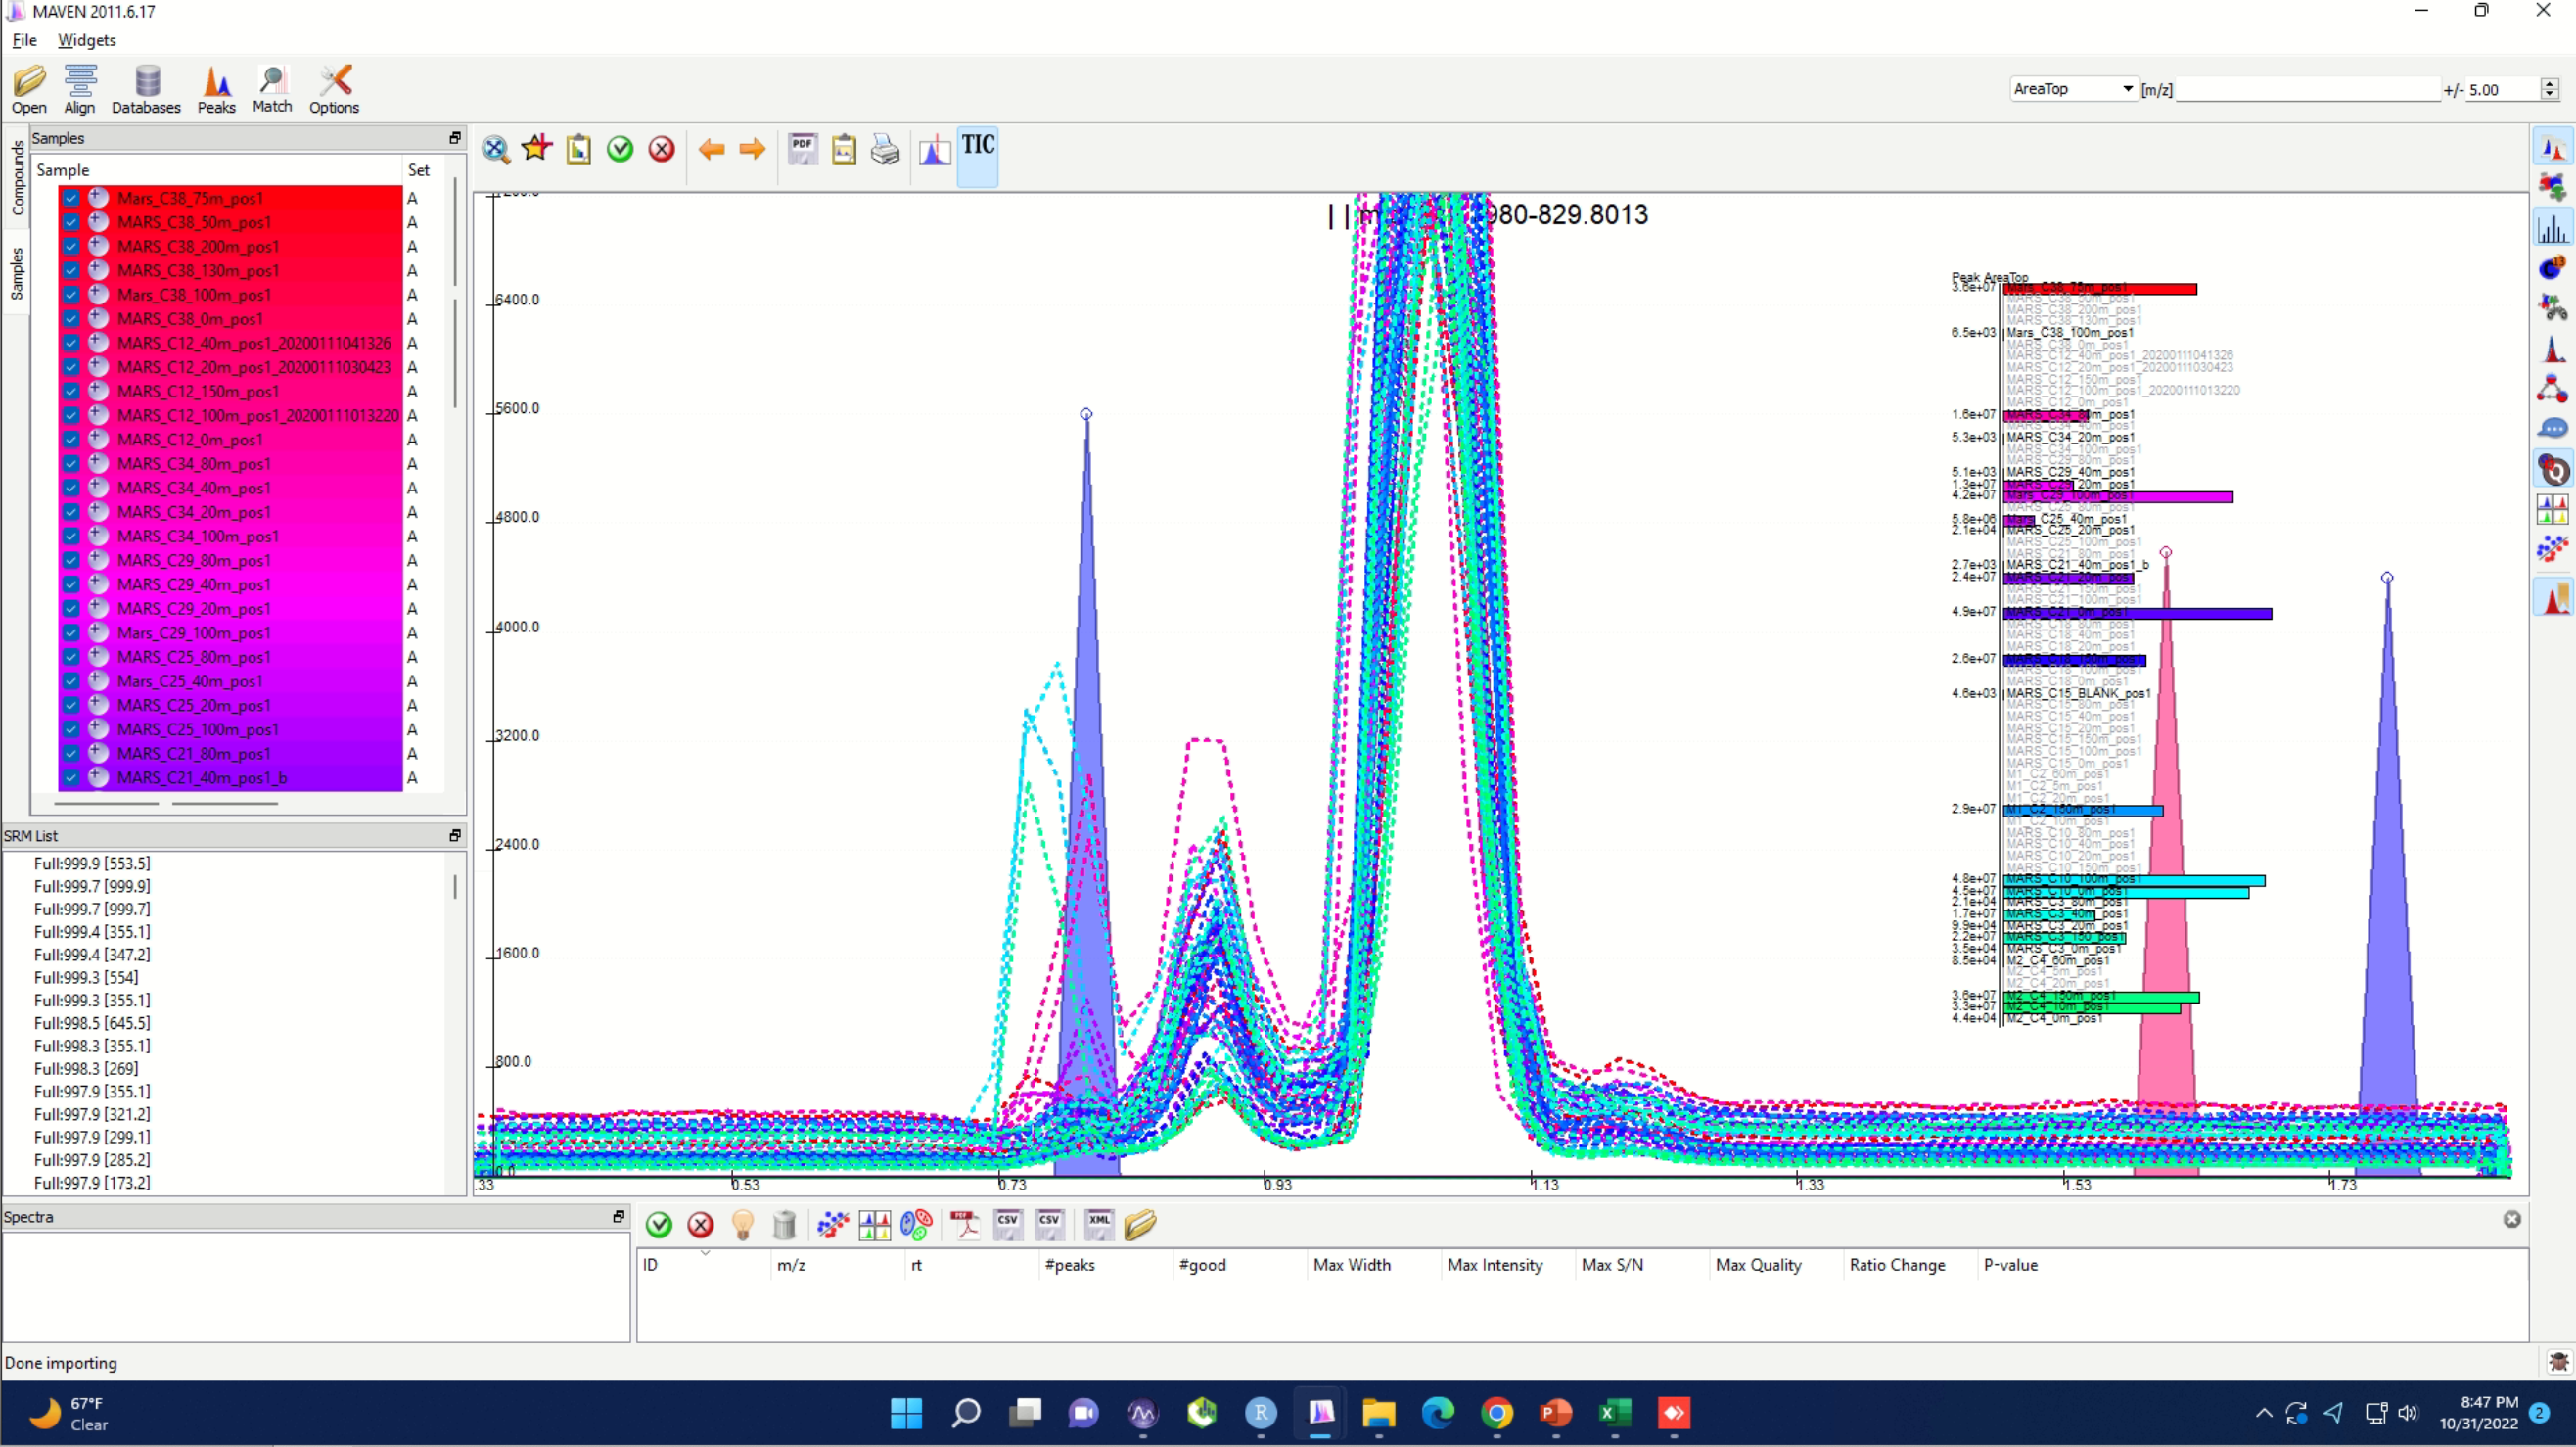

In [24]:
ex_solvent_front=combined_info[(combined_info["peakgroup_rt"]/60)>1.1].index.to_list()
combined_norm_PE_sf=combined_norm_PE.loc[ex_solvent_front]
combined_norm_PE_sf.to_csv("final_raw_norm_PE_sf.csv")

### Remove unlikely oxidations 

<div class="alert alert-block alert-warning">
Would be best if we can set filtering based on # of oxidations & DB etc.. but for now we are using manually organized spreadsheet
</div>

Criteria: 
(1) If there are no double bonds, there can be no oxidations
(2) If there are 3 or 4 double bonds, there can be no less than 30 carbons
(2-1) The exception to this rule is FFA, MAG, Lyso

In [42]:
oxi=pd.read_csv("/Users/jiwoonhwang/Desktop/MBTS/October 2022/unusual_oxidations.csv", index_col=0, low_memory=False)
combined_norm_PE_sf_oxi=combined_norm_PE_sf[~combined_norm_PE_sf.index.isin(oxi.index.to_list())]

### Subtract BLANK

In [27]:
def sub_blank(combined_norm):
    
    #REPLACE ZERO VALUES WITH NAN
    combined_norm=combined_norm.replace(0,np.NaN)
    
    #FIND AVERAGE OF BLANK TRIPLICATES
    boolean=[]
    for col in combined_norm.columns:
        col_split=col.split("_")
        if len(col_split)>3:
            if col_split[2]== 'BLANK':
                boolean.append(True)
            else: boolean.append(False)
        else: boolean.append(False)

    choose=combined_norm.loc[:,boolean]
    choose['average']=choose.mean(axis=1)
    
    #SUBTRACT BLANK FROM ALL VALUES
    choose['average']=choose['average'].fillna(0)
    combined_sub=combined_norm.sub(choose['average'], axis=0)

    #REMOVE BLANK FROM COLUMNS
    boolean=[]
    for col in combined_sub.columns:
        col_split=col.split("_")
        if len(col_split)>3:
            if col_split[2]== 'BLANK':
                boolean.append(False)
            else: boolean.append(True)
        else: boolean.append(True)

    combined_sub=combined_sub.loc[:,boolean]
    
    ##REPLACE MINUS VALUES WITH ZERO
    df1=combined_sub.copy()
    df1[df1<0]=0
    df1=df1.fillna(0)
    
    return (df1)

In [43]:
combined_sub_PE=sub_blank(combined_norm_PE_sf_oxi).sort_index().sort_index(axis=1)
combined_sub_PE.to_csv("final_raw_norm_PE_sf_sub.csv")

/var/folders/ym/lsk3txk57xb_wzgsxbrb83tw0000gn/T/ipykernel_10856/1128285080.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  choose['average']=choose.mean(axis=1)
/var/folders/ym/lsk3txk57xb_wzgsxbrb83tw0000gn/T/ipykernel_10856/1128285080.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  choose['average']=choose['average'].fillna(0)


## Quantification

In [8]:
info=pd.read_csv("/Users/jiwoonhwang/Desktop/MBTS/20min_method/Positive/LOB_Peaklist_Pos_noNA.csv", low_memory=False)
info[~info["species"].isin(lst)]["species"].value_counts()

PA                 73
LPG                 5
Neox_Nos            2
Viol                2
Pras                2
Zeax                1
Lut                 1
fngGSL(17:1_OH)     1
fngGSL(14:0_OH)     1
Name: species, dtype: int64

In [491]:
'''Positive Compounds'''

path ="/Users/jiwoonhwang/Desktop/MBTS/standard curve/for linear regression.csv"
df =pd.read_csv(path, index_col=0, low_memory=False)

combined_pos=pd.concat([template1, template2, template5])
combined_pos_info=pd.concat([template1_info, template2_info, template5_info])

raw_df=combined_pos
raw_df_info=combined_pos_info
absolute_df=pd.DataFrame(columns=raw_df.columns, index=raw_df.index)

for i in df.index:
    y=np.array(df.columns.astype("float"))
    x=np.array(df.loc[i])
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    
    rel=raw_df.loc[raw_df_info[raw_df_info["species"].isin(std_species[i])].index]
#     rel=raw_df[raw_df.index.str.startswith(i)]
    absolute_df.loc[rel.index]=poly1d_fn(rel.values.astype("float"))
    #missing=raw_df.loc[raw_df_info[~raw_df_info["species"].isin(std_species[i])].index]
    
# missing=raw_df_info[~raw_df_info["species"].isin(lst)]
# print(missing["species"].tolist())
# print (absolute_df.iloc[:,0].astype("float").idxmax(axis=1))
# print (absolute_df.iloc[:,0].sort_values(ascending=False))

LMGDG 16:3 +4O
LMGDG 16:3 +4O      2948.05
PC 38:6             340.237
Chl_a               168.779
LMGDG 13:1 +3O      156.296
PC 44:12            94.9935
                    ...    
TAG 32:6 +1O       0.016034
TAG 54:0 +3O      0.0160127
TAG 34:1          0.0159608
TAG 54:4 +2O      0.0159549
TAG 52:0 +4O      0.0158537
Name: MARS_C25_000m_1, Length: 1037, dtype: object


In [596]:
'''Negative Compounds'''

path ="/Users/jiwoonhwang/Desktop/MBTS/standard curve/for linear regression_neg.csv"
df_neg =pd.read_csv(path, index_col=0, low_memory=False)

raw_df=template4
raw_df_info=template4_info
absolute_df_neg=pd.DataFrame(columns=raw_df.columns, index=raw_df.index)

for i in df_neg.index:
    y=np.array(df_neg.columns.astype("float"))
    x=np.array(df_neg.loc[i])
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    
    rel=raw_df.loc[raw_df_info[raw_df_info["species"].isin(std_species[i])].index]
#     rel=raw_df[raw_df.index.str.startswith(i)]
    absolute_df_neg.loc[rel.index]=poly1d_fn(rel.values.astype("float"))
    #missing=raw_df.loc[raw_df_info[~raw_df_info["species"].isin(std_species[i])].index]
    
# missing=raw_df_info[~raw_df_info["species"].isin(lst)]
# print(missing["species"].tolist())
# print (absolute_df.iloc[:,0].astype("float").idxmax(axis=1))
# print (absolute_df_neg.iloc[:,0].sort_values(ascending=False))

compound_name
FFA 22:6                     34.5818
FFA 20:5_RT:423.627          25.1741
FFA 18:0_RT:648.967           10.523
FFA 16:0_RT:552.086          9.28194
FFA 18:0_RT:916.349           7.4518
                             ...    
FFA 16:3 +3O               0.0362308
FFA 12:3 +4O               0.0345844
FFA 16:3 +2O_RT:150.979    0.0316242
FFA 16:3 +2O_RT:241.318    0.0292546
FFA 22:4 +4O               0.0285319
Name: MARS_C25_000m_1, Length: 82, dtype: object


In [596]:
'''Pigment Compounds'''

path ="/Users/jiwoonhwang/Desktop/MBTS/pigment standards/MeOH+DCM/for linear regression.csv"
df_pig =pd.read_csv(path, index_col=0, low_memory=False)

raw_df=combined_pos
raw_df_info=combined_pos_info
absolute_df_pig=pd.DataFrame(columns=raw_df.columns, index=raw_df.index)

for i in df_pig.index:
    y=np.array(df_pig.columns.astype("float"))
    x=np.array(df_pig.loc[i])
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    
    rel=raw_df.loc[raw_df_info[raw_df_info["species"].isin(std_species[i])].index]
    absolute_df_pig.loc[rel.index]=poly1d_fn(rel.values.astype("float"))

compound_name
FFA 22:6                     34.5818
FFA 20:5_RT:423.627          25.1741
FFA 18:0_RT:648.967           10.523
FFA 16:0_RT:552.086          9.28194
FFA 18:0_RT:916.349           7.4518
                             ...    
FFA 16:3 +3O               0.0362308
FFA 12:3 +4O               0.0345844
FFA 16:3 +2O_RT:150.979    0.0316242
FFA 16:3 +2O_RT:241.318    0.0292546
FFA 22:4 +4O               0.0285319
Name: MARS_C25_000m_1, Length: 82, dtype: object


In [629]:
combined_abs=pd.concat([absolute_df,absolute_df_neg, absolute_df_pig]).sort_index().sort_index(axis=1)

In [630]:
combined_abs.to_csv("final_absolute.csv")

### Normalization of quantified peaks

In [614]:
absolute_df_norm=pd.DataFrame(columns=absolute_df.columns)

for i in list(std_species.keys()):
    if i in std_pos.index:
        to_norm=absolute_df.loc[combined_pos_info[combined_pos_info["species"].isin(std_species[i])].index]
        #print (i, to_norm.index)

        ##find highest value
        value=std_pos.loc[[i]].max(axis=1)
        #print "This is the highest value: " +str(value)

        ##calculate normalizing factor
        std= std_pos.loc[[i]].apply(lambda row: row/float(value), axis=1)
        factor= std.iloc[0,:]

        ##apply factor to peaklist
        temp=to_norm.apply(lambda row: row/factor, axis=1)
        absolute_df_norm=pd.concat([absolute_df_norm, temp])

len(absolute_df_norm)==len(absolute_df)

True

In [616]:
absolute_df_neg_norm=pd.DataFrame(columns=absolute_df_neg.columns)

for i in list(std_species.keys()):
    if i in standard_neg.index:
        to_norm=absolute_df_neg.loc[template4_info[template4_info["species"].isin(std_species[i])].index]
        #print (i, to_norm.index)

        ##find highest value
        value=standard_neg.loc[[i]].max(axis=1)
        #print "This is the highest value: " +str(value)

        ##calculate normalizing factor
        std= standard_neg.loc[[i]].apply(lambda row: row/float(value), axis=1)
        factor= std.iloc[0,:]

        ##apply factor to peaklist
        temp=to_norm.apply(lambda row: row/factor, axis=1)
        absolute_df_neg_norm=pd.concat([absolute_df_neg_norm, temp])

len(absolute_df_neg_norm)==len(absolute_df_neg)

True

In [618]:
combined_abs_norm=pd.concat([absolute_df_neg_norm, absolute_df_norm])
combined_abs_norm.to_csv("final_absolute_norm.csv")

In [658]:
combined_abs_norm_sub=sub_blank(combined_abs_norm).sort_index().sort_index(axis=1)
combined_abs_norm_sub.to_csv("final_absolute_norm_sub.csv")

<ipython-input-619-30dacb2b4505>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  choose['average']=choose.mean(axis=1)
<ipython-input-619-30dacb2b4505>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  choose['average']=choose['average'].fillna(0)


## Only surface, MARS

In [33]:
def surface(df):
    surface = []
    for i in df.columns:
        i_split=i.split("_")
        if i_split[2] in ("000m"):
            surface.append(i)
    return (df[surface])

def MARS(template):
    boolean=[]
    for col in template.columns:
        col_split=col.split("_")
        if len(col_split)>3:
            if col_split[0]== "MARS":
                boolean.append(True)
            else: boolean.append(False)
        else: boolean.append(False)

    #print (boolean)

    template=template.loc[:,boolean]

    return(template)

In [676]:
combined_abs_surface=MARS(surface(combined_abs_norm_sub))
combined_abs_surface.to_csv("final_absolute_norm_sub_MARS_surface.csv")

In [44]:
combined_PE_surface=MARS(surface(combined_sub_PE))
combined_PE_surface.to_csv("final_raw_norm_PE_sf_sub_MARS_surface.csv")

## Zero filtering

In [35]:
def zero_filter(df_r):

    df_r["num_zeros"]=(df_r.astype(float)==0).sum(axis=1)
    df_f=df_r[df_r["num_zeros"]<len(df_r.columns)/4].iloc[:,0:-1]
    
    diff=len(df_r.index)-len(df_f)-1
    print ("The number of rows reduced is: " + str(diff))
    
    reduced=df_r.loc[df_f.index].iloc[:,:-1]
    return (reduced)

In [45]:
combined_PE_zf=zero_filter(combined_PE_surface)
combined_PE_zf.to_csv("final_raw_norm_PE_sf_sub_surface_25_zero_filtered.csv")

The number of rows reduced is: 203


#### IPL, TAG, FFA for WGCNA

In [36]:
ipl_tag_ffa=["IP_DAG", "IP_MAG", "TAG", "FFA"]
df_con=pd.concat([combined_zf, combined_info[["species","lipid_class"]]], axis=1, join="inner")
ipl_tag_ffa_df=combined_zf.loc[df_con[df_con["lipid_class"].isin(ipl_tag_ffa)].index]
ipl_tag_ffa_df
ipl_tag_ffa_df.to_csv("/Users/jiwoonhwang/Desktop/MBTS/October 2022/final_raw_norm_sub_MARS_surface_zf_ipl_tag_ffa.csv")

In [49]:
ipl_ffa=["IP_DAG", "IP_MAG", "FFA"]
ipl_tag_ffa=["IP_DAG", "IP_MAG", "TAG", "FFA"]
df_con_PE=pd.concat([combined_PE_zf, combined_info[["species","lipid_class"]]], axis=1, join="inner")

ipl_ffa_df_PE=combined_PE_zf.loc[df_con_PE[df_con_PE["lipid_class"].isin(ipl_ffa)].index]
ipl_ffa_df_PE
ipl_ffa_df_PE.to_csv("/Users/jiwoonhwang/Desktop/MBTS/October 2022/final_raw_norm_PE_sf_sub_MARS_surface_zf_ipl_ffa.csv")

ipl_tag_ffa_df_PE=combined_PE_zf.loc[df_con_PE[df_con_PE["lipid_class"].isin(ipl_tag_ffa)].index]
ipl_tag_ffa_df_PE
ipl_tag_ffa_df_PE.to_csv("/Users/jiwoonhwang/Desktop/MBTS/October 2022/final_raw_norm_PE_sf_sub_MARS_surface_zf_ipl_tag_ffa.csv")